# Lasso and Ridge Linear Regression with Cross-validation

#### This notebook has four main sections

## A. Imports, data shaping, and preprocessing

## B. Lasso CV regression on all features

## C. Lasso and Ridge regression on all features except `rating count`

## D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

# A. Imports and data shaping

In [281]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [282]:
pd.options.display.float_format = "{:,.5f}".format

In [283]:
#director = 'godard'
#director = 'hitchcock'
#director = 'bergman'
#director = 'fassbinder'
#director = 'herzog'
#director = 'allen'
director='fassbinder'

In [284]:

dir_str = director + '/'

films_filename = 'films_to_analyze_' + director
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [285]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,"1,982.00000",8 September 1982 (France),108.00000,108.00000,"4,400,000.00000",NaN,NaN,NaN,6.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",13 May 1982 (Netherlands),104.00000,104.00000,"2,600,000.00000","8,144.00000","8,144.00000",NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Lola,"1,981.00000",4 August 1982 (USA),115.00000,115.00000,"3,500,000.00000","8,144.00000","8,144.00000",NaN,7.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",13 August 1984 (Denmark),91.00000,91.00000,"220,000.00000",NaN,NaN,NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",14 January 1981 (West Germany),120.00000,120.00000,"10,500,000.00000","8,144.00000","8,144.00000",NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [286]:
prevalent_actors_filename  = 'prevalent_actors_' + director
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [287]:
prevalent_actor_columns

Index(['Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler', 'Harry Baer', 'Hark Bohm',
       'Walter Sedlmayr', 'Gottfried John', 'Rudolf Waldemar Brem',
       'Katrin Schaake', 'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven',
       'El Hedi ben Salem', 'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal',
       'Doris Mattes', 'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober',
       'Hannes Gromball', 'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny',
       'Elisabeth Trissenaar', 'Margarethe von Trotta', 'Eddie Constantine',
       'Isolde Barth', 'Carla Egerer', 'Franz Maron', 'Claus Holm',
       'Barbara Sukowa', 'Christine Kaufmann', 'Herbert Steinmetz',
       'Karl-Heinz von Hassel', 'Sonja N

In [288]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [289]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [290]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kauf

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [291]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Christa Berndl,Anne-Marie Kuster,Heide Grübl,Andrea Grosske,Anna Karina,Macha Méril,Helen Vita,Heli Finkenzeller,Elke Aberle,Thomas Fengler
0,Querelle,"1,982.00000",8 September 1982 (France),108.00000,108.00000,"4,400,000.00000",NaN,NaN,NaN,6.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",13 May 1982 (Netherlands),104.00000,104.00000,"2,600,000.00000","8,144.00000","8,144.00000",NaN,7.80000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Lola,"1,981.00000",4 August 1982 (USA),115.00000,115.00000,"3,500,000.00000","8,144.00000","8,144.00000",NaN,7.50000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",13 August 1984 (Denmark),91.00000,91.00000,"220,000.00000",NaN,NaN,NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",14 January 1981 (West Germany),120.00000,120.00000,"10,500,000.00000","8,144.00000","8,144.00000",NaN,7.10000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [292]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [293]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Hanna Schygulla,Kurt Raab,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,Querelle,"1,982.00000",108.00000,Xaver Schwarzenberger,0,0,6.80000,"5,824.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Veronika Voss,"1,982.00000",104.00000,Xaver Schwarzenberger,0,0,7.80000,"6,238.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
2,Lola,"1,981.00000",115.00000,Xaver Schwarzenberger,0,0,7.50000,"5,273.00000",0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000
3,Theater in Trance,"1,981.00000",91.00000,Werner Lüring,1,0,7.10000,97.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Lili Marleen,"1,981.00000",120.00000,Xaver Schwarzenberger,0,0,7.10000,"3,571.00000",1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000


In [294]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [295]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [296]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Hanna Schygulla', 'Kurt Raab',
       'Lilo Pempeit', 'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann',
       'Ulli Lommel', 'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler',
       'Harry Baer', 'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus

In [297]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [298]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kaufmann',
 'Herbert Stei

In [299]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [300]:
y.isnull().values.any()

False

### Train-val vs. test split

In [301]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [302]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Hanna Schygulla,Kurt Raab,Lilo Pempeit,Irm Hermann,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
34,"1,970.00000",90.00000,Dietrich Lohmann,0,1,498.00000,1.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
38,"1,970.00000",91.00000,Dietrich Lohmann,0,0,"1,208.00000",1.00000,0.00000,1.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"1,981.00000",120.00000,Xaver Schwarzenberger,0,0,"3,571.00000",1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
13,"1,976.00000",86.00000,Michael Ballhaus,0,0,"3,687.00000",0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
31,"1,971.00000",95.00000,Michael Ballhaus,0,0,977.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
27,"1,972.00000",87.00000,Dietrich Lohmann,0,1,209.00000,1.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,979.00000",111.00000,Rainer Werner Fassbinder,0,0,"2,116.00000",1.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
28,"1,972.00000",124.00000,Michael Ballhaus,0,0,"8,545.00000",1.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [303]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [304]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [305]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Dietrich Lohmann',
       'cinematographer_Jürgen Jürges',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER',
       'cinematographer_Rainer Werner Fassbinder',
       'cinematographer_Xaver Schwarzenberger'], dtype=object)

In [306]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Rainer Werner Fassbinder,cinematographer_Xaver Schwarzenberger
25,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
17,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
8,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
16,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000


Repeating transformations on testing set

In [307]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [308]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
25,"1,972.00000",476.00000,354.00000
15,"1,976.00000",104.00000,"1,144.00000"
17,"1,975.00000",108.00000,"1,738.00000"
8,"1,978.00000",124.00000,"3,697.00000"
16,"1,975.00000",88.00000,"1,550.00000"


#### Generate log and polynomials

In [309]:
#X_train_val_cont_poly.head()

In [310]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-310-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-310-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-310-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [311]:
X_test_cont.shape[0]

8

#### Concatenate columns

In [312]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [313]:
X_test_cat_df.isnull().values.any()

False

In [314]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [315]:
X_test_cat_df.shape

(8, 56)

In [316]:
X_train_val_combo.isnull().values.any()

False

In [317]:
X_test_combo.isnull().values.any()

False

In [318]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Rainer Werner Fassbinder,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,"1,970.00000",90.00000,498.00000,7.58579,6.21060,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"1,970.00000",91.00000,"1,208.00000",7.58579,7.09672,1.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,981.00000",120.00000,"3,571.00000",7.59136,8.18060,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
3,"1,976.00000",86.00000,"3,687.00000",7.58883,8.21257,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
4,"1,971.00000",95.00000,977.00000,7.58630,6.88449,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,972.00000",87.00000,209.00000,7.58680,5.34233,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,979.00000",111.00000,"2,116.00000",7.59035,7.65728,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
7,"1,972.00000",124.00000,"8,545.00000",7.58680,9.05310,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [319]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Dietrich Lohmann', 'cinematographer_Jürgen Jürges',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER',
       'cinematographer_Rainer Werner Fassbinder',
       'cinematographer_Xaver Schwarzenberger', 'documentary', 'tv_series',
       'Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann',
       'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven',
       'Karl Scheydt', 'Volker Spengler', 'Harry Baer', 'Hark Bohm',
       'Walter Sedlmayr', 'Gottfried John', 'Rudolf Waldemar Brem',
       'Katrin Schaake', 'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven',
       'El Hedi ben Salem', 'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal',
       'Doris Mattes', 'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz'

### Train vs. val split

In [320]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

In [321]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

## B. Lasso CV regression on all features


### Lasso CV

In [322]:
X_train_val_combo.values

array([[1.972e+03, 4.760e+02, 3.540e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.976e+03, 1.040e+02, 1.144e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.975e+03, 1.080e+02, 1.738e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.976e+03, 1.120e+02, 1.741e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.972e+03, 8.800e+01, 4.262e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.969e+03, 8.800e+01, 2.739e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [323]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [324]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [325]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [326]:
# This is the best alpha value it found 
lasso_model.alpha_

0.05542664520663107

In [327]:
len(lasso_model.coef_)

67

In [328]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.1831142632170983),
 ('rating_count', 0.1257498338830108),
 ('log_year', 0.0),
 ('log_rating_count', 0.0),
 ('cinematographer_Dietrich Lohmann', -0.0),
 ('cinematographer_Jürgen Jürges', 0.0),
 ('cinematographer_Michael Ballhaus', -0.0),
 ('cinematographer_OTHER', 0.0),
 ('cinematographer_Rainer Werner Fassbinder', 0.0),
 ('cinematographer_Xaver Schwarzenberger', 0.0),
 ('documentary', -0.0),
 ('tv_series', 0.0),
 ('Hanna Schygulla', -0.0),
 ('Kurt Raab', 0.0),
 ('Lilo Pempeit', 0.0),
 ('Irm Hermann', 0.0),
 ('Margit Carstensen', 0.0),
 ('Günther Kaufmann', -0.0),
 ('Ulli Lommel', -0.17923051213519697),
 ('Ingrid Caven', 0.0),
 ('Karl Scheydt', 0.0),
 ('Volker Spengler', 0.0),
 ('Harry Baer', -0.0),
 ('Hark Bohm', 0.0),
 ('Walter Sedlmayr', 0.0),
 ('Gottfried John', 0.06732036849483454),
 ('Rudolf Waldemar Brem', -0.0),
 ('Katrin Schaake', -0.0),
 ('Brigitte Mira', 0.051125691597811856),
 ('Klaus Löwitsch', -0.0),
 ('Adrian Hoven', 0.013019070750821059),


In [329]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [330]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3855682468916599

In [331]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.005956057008811633

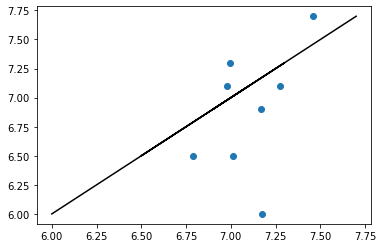

In [332]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

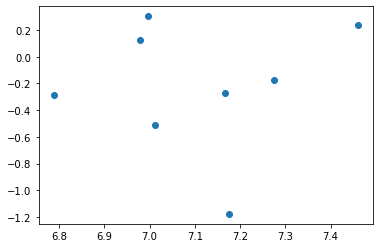

In [333]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [420]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(20)

,Feature,Coefficient
1,duration,0.02913
17,Ulli Lommel,-0.02900
14,Irm Hermann,0.02865
23,Walter Sedlmayr,0.02575
30,El Hedi ben Salem,0.02240
24,Gottfried John,0.02185
52,Margarethe von Trotta,-0.02137
32,Peter Moland,-0.01919
41,Armin Meier,-0.01855
25,Rudolf Waldemar Brem,0.01794


In [335]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3855682468916599,
 'coefficients':                   Feature  Coefficient
 1                duration      0.18311
 19            Ulli Lommel     -0.17923
 2            rating_count      0.12575
 44       Wolfgang Schenck      0.07516
 26         Gottfried John      0.06732
 ..                    ...          ...
 34           Peter Moland     -0.00000
 8   cinematographer_OTHER      0.00000
 36           Doris Mattes      0.00000
 37                Y Sa Lo     -0.00000
 0                    year      0.00000
 
 [67 rows x 2 columns]}

In [336]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_' + director
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

## C. Lasso and Ridge regression on all features except `rating count`



### Rerun the model without using rating count

In [337]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Dietrich Lohmann,cinematographer_Jürgen Jürges,cinematographer_Michael Ballhaus,cinematographer_OTHER,cinematographer_Rainer Werner Fassbinder,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,-0.80752,2.05319,-0.74703,-0.80741,-1.19229,1.56347,-0.32733,-0.79472,-0.26261,-0.18257,...,-0.26261,-0.26261,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.18257
1,0.20392,-0.26949,-0.53972,0.20494,-0.28952,-0.63960,-0.32733,1.25831,-0.26261,-0.18257,...,-0.26261,-0.26261,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.32733,3.80789,-0.18257
2,-0.04894,-0.24451,-0.38384,-0.04796,0.03234,-0.63960,-0.32733,1.25831,-0.26261,-0.18257,...,-0.26261,-0.26261,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.18257
3,0.70964,-0.14461,0.13025,0.71035,0.61325,-0.63960,-0.32733,-0.79472,-0.26261,5.47723,...,-0.26261,-0.26261,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.32733,-0.26261,-0.18257
4,-0.04894,-0.36939,-0.43317,-0.04796,-0.05577,-0.63960,3.05505,-0.79472,-0.26261,-0.18257,...,-0.26261,-0.26261,-0.26261,-0.32733,-0.26261,3.05505,-0.26261,-0.32733,-0.26261,-0.18257


In [338]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [339]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [340]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [341]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

0.04824108704165369

In [342]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

In [343]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [344]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.42112784384763213

In [345]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.31772085594912736

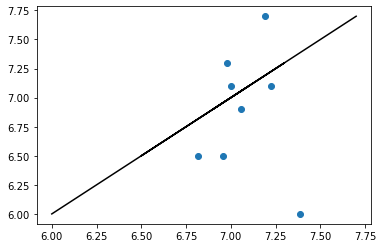

In [346]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

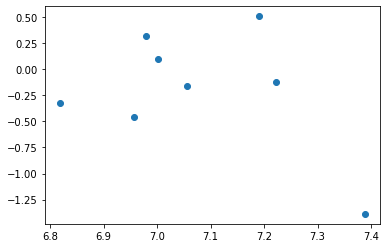

In [347]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [348]:
coefficients_df.head()

,Feature,Coefficient
1,duration,0.19359
27,Brigitte Mira,0.06759
42,Wolfgang Schenck,0.06226
23,Walter Sedlmayr,0.06083
24,Gottfried John,0.06021


In [349]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.42112784384763213,
 'coefficients':              Feature  Coefficient
 1           duration      0.19359
 27     Brigitte Mira      0.06759
 42  Wolfgang Schenck      0.06226
 23   Walter Sedlmayr      0.06083
 24    Gottfried John      0.06021
 ..               ...          ...
 37        Eva Mattes     -0.02824
 49       Roger Fritz     -0.03990
 64          Udo Kier     -0.04898
 55      Carla Egerer     -0.08650
 17       Ulli Lommel     -0.18430
 
 [65 rows x 2 columns]}

In [350]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_' + director
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [351]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


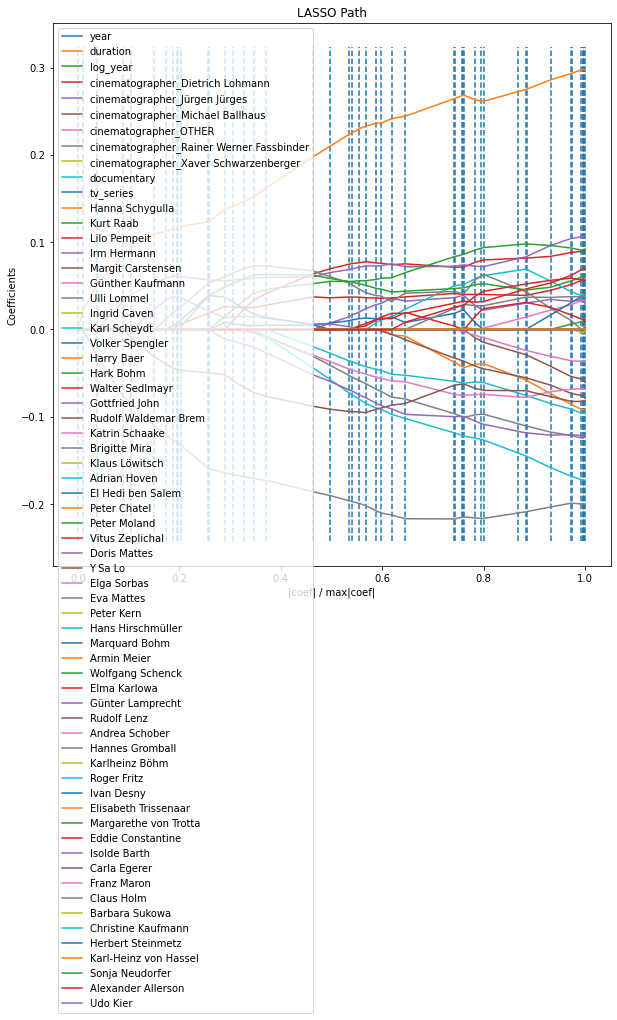

In [352]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [353]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [354]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
17,Ulli Lommel,-0.04866
1,duration,0.04552
24,Gottfried John,0.03941
55,Carla Egerer,-0.03263
36,Elga Sorbas,-0.02726
...,...,...
38,Peter Kern,0.00177
25,Rudolf Waldemar Brem,-0.00148
51,Elisabeth Trissenaar,-0.00144
18,Ingrid Caven,0.00142


In [355]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [356]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.4374696486687405

In [357]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


-0.21232984061357074

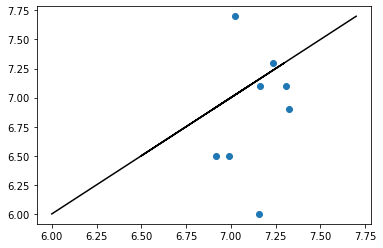

In [358]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

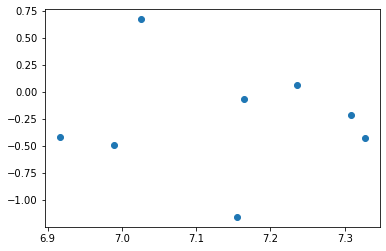

In [359]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [360]:
coefficients_df.head()

,Feature,Coefficient
17,Ulli Lommel,-0.04866
1,duration,0.04552
24,Gottfried John,0.03941
55,Carla Egerer,-0.03263
36,Elga Sorbas,-0.02726


In [361]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.4374696486687405,
 'coefficients':                   Feature  Coefficient
 17            Ulli Lommel     -0.04866
 1                duration      0.04552
 24         Gottfried John      0.03941
 55           Carla Egerer     -0.03263
 36            Elga Sorbas     -0.02726
 ..                    ...          ...
 38             Peter Kern      0.00177
 25   Rudolf Waldemar Brem     -0.00148
 51   Elisabeth Trissenaar     -0.00144
 18           Ingrid Caven      0.00142
 6   cinematographer_OTHER     -0.00003
 
 [65 rows x 2 columns]}

In [362]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc_' + director
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

## D. Lasso and Ridge regression on all features except `rating count` but with also `budget` added as a feature

#### Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [363]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [364]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [365]:
analysis_columns 

['title',
 'year',
 'duration',
 'budget',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'Hanna Schygulla',
 'Kurt Raab',
 'Lilo Pempeit',
 'Irm Hermann',
 'Margit Carstensen',
 'Günther Kaufmann',
 'Ulli Lommel',
 'Ingrid Caven',
 'Karl Scheydt',
 'Volker Spengler',
 'Harry Baer',
 'Hark Bohm',
 'Walter Sedlmayr',
 'Gottfried John',
 'Rudolf Waldemar Brem',
 'Katrin Schaake',
 'Brigitte Mira',
 'Klaus Löwitsch',
 'Adrian Hoven',
 'El Hedi ben Salem',
 'Peter Chatel',
 'Peter Moland',
 'Vitus Zeplichal',
 'Doris Mattes',
 'Y Sa Lo',
 'Elga Sorbas',
 'Eva Mattes',
 'Peter Kern',
 'Hans Hirschmüller',
 'Marquard Bohm',
 'Armin Meier',
 'Wolfgang Schenck',
 'Elma Karlowa',
 'Günter Lamprecht',
 'Rudolf Lenz',
 'Andrea Schober',
 'Hannes Gromball',
 'Karlheinz Böhm',
 'Roger Fritz',
 'Ivan Desny',
 'Elisabeth Trissenaar',
 'Margarethe von Trotta',
 'Eddie Constantine',
 'Isolde Barth',
 'Carla Egerer',
 'Franz Maron',
 'Claus Holm',
 'Barbara Sukowa',
 'Christine Kaufmann',

In [366]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [367]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

3

In [368]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [369]:
films_and_features_to_analyze_df.columns

Index(['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'Hanna Schygulla', 'Kurt Raab', 'Lilo Pempeit',
       'Irm Hermann', 'Margit Carstensen', 'Günther Kaufmann', 'Ulli Lommel',
       'Ingrid Caven', 'Karl Scheydt', 'Volker Spengler', 'Harry Baer',
       'Hark Bohm', 'Walter Sedlmayr', 'Gottfried John',
       'Rudolf Waldemar Brem', 'Katrin Schaake', 'Brigitte Mira',
       'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem', 'Peter Chatel',
       'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes', 'Y Sa Lo',
       'Elga Sorbas', 'Eva Mattes', 'Peter Kern', 'Hans Hirschmüller',
       'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck', 'Elma Karlowa',
       'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober', 'Hannes Gromball',
       'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny', 'Elisabeth Trissenaar',
       'Margarethe von Trotta', 'Eddie Constantine', 'Isolde Barth',
       'Carla Egerer', 'Franz Maron', 'Claus Holm'

In [370]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [371]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [372]:
X

,year,duration,budget,cinematographer,documentary,tv_series,Hanna Schygulla,Kurt Raab,Lilo Pempeit,Irm Hermann,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
1,"1,982.00000",104.00000,"2,600,000.00000",OTHER,0,0,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
2,"1,981.00000",115.00000,"3,500,000.00000",OTHER,0,0,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000
4,"1,981.00000",120.00000,"10,500,000.00000",OTHER,0,0,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
7,"1,979.00000",120.00000,"1,975,000.00000",Michael Ballhaus,0,0,1.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
9,"1,978.00000",119.00000,"6,000,000.00000",Michael Ballhaus,0,0,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
11,"1,977.00000",201.00000,"1,800,000.00000",Michael Ballhaus,0,1,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000
13,"1,976.00000",86.00000,"1,100,000.00000",Michael Ballhaus,0,0,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
14,"1,976.00000",112.00000,"600,000.00000",Michael Ballhaus,0,0,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
16,"1,975.00000",88.00000,"375,000.00000",OTHER,0,1,0.00000,1.00000,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
17,"1,975.00000",108.00000,"750,000.00000",Michael Ballhaus,0,0,0.00000,1.00000,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [373]:
y.isnull().values.any()

False

In [374]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [375]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

In [376]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [377]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [378]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Dietrich Lohmann',
       'cinematographer_Michael Ballhaus', 'cinematographer_OTHER'],
      dtype=object)

In [379]:
cat_ohe.shape[0]

16

In [380]:
X_train_val_cat_ohe.shape[0]

16

In [381]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Dietrich Lohmann,cinematographer_Michael Ballhaus,cinematographer_OTHER
11,0.00000,1.00000,0.00000
20,0.00000,0.00000,1.00000
7,0.00000,1.00000,0.00000
38,1.00000,0.00000,0.00000
30,0.00000,1.00000,0.00000


In [382]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [383]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

,year,duration,budget
11,"1,977.00000",201.00000,"1,800,000.00000"
20,"1,974.00000",135.00000,"750,000.00000"
7,"1,979.00000",120.00000,"1,975,000.00000"
38,"1,970.00000",91.00000,"180,000.00000"
30,"1,971.00000",103.00000,"1,100,000.00000"


In [384]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

<ipython-input-384-02b26dca41c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-384-02b26dca41c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
<ipython-input-384-02b26dca41c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [385]:
X_test_cont.shape[0]

5

#### Concatenate columns

In [386]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [387]:
X_test_cat_df.isnull().values.any()

False

In [388]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [389]:
X_test_cat_df.shape

(5, 56)

In [390]:
X_train_val_combo.isnull().values.any()

False

In [391]:
X_test_combo.isnull().values.any()

False

In [392]:
X_test_combo

,year,duration,budget,log_year,log_budget,budget_sq,cinematographer_Dietrich Lohmann,cinematographer_Michael Ballhaus,cinematographer_OTHER,documentary,...,Carla Egerer,Franz Maron,Claus Holm,Barbara Sukowa,Christine Kaufmann,Herbert Steinmetz,Karl-Heinz von Hassel,Sonja Neudorfer,Alexander Allerson,Udo Kier
0,"1,982.00000",104.00000,"2,600,000.00000",7.59186,14.77102,"6,760,000,000,000.00000",0.00000,0.00000,1.00000,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000
1,"1,970.00000",80.00000,"280,000.00000",7.58579,12.54254,"78,400,000,000.00000",1.00000,0.00000,0.00000,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"1,972.00000",88.00000,"325,000.00000",7.58680,12.69158,"105,625,000,000.00000",1.00000,0.00000,0.00000,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"1,981.00000",115.00000,"3,500,000.00000",7.59136,15.06827,"12,250,000,000,000.00000",0.00000,0.00000,1.00000,0,...,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000
4,"1,975.00000",88.00000,"375,000.00000",7.58832,12.83468,"140,625,000,000.00000",0.00000,0.00000,1.00000,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000


In [393]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'budget', 'log_year', 'log_budget', 'budget_sq',
       'cinematographer_Dietrich Lohmann', 'cinematographer_Michael Ballhaus',
       'cinematographer_OTHER', 'documentary', 'tv_series', 'Hanna Schygulla',
       'Kurt Raab', 'Lilo Pempeit', 'Irm Hermann', 'Margit Carstensen',
       'Günther Kaufmann', 'Ulli Lommel', 'Ingrid Caven', 'Karl Scheydt',
       'Volker Spengler', 'Harry Baer', 'Hark Bohm', 'Walter Sedlmayr',
       'Gottfried John', 'Rudolf Waldemar Brem', 'Katrin Schaake',
       'Brigitte Mira', 'Klaus Löwitsch', 'Adrian Hoven', 'El Hedi ben Salem',
       'Peter Chatel', 'Peter Moland', 'Vitus Zeplichal', 'Doris Mattes',
       'Y Sa Lo', 'Elga Sorbas', 'Eva Mattes', 'Peter Kern',
       'Hans Hirschmüller', 'Marquard Bohm', 'Armin Meier', 'Wolfgang Schenck',
       'Elma Karlowa', 'Günter Lamprecht', 'Rudolf Lenz', 'Andrea Schober',
       'Hannes Gromball', 'Karlheinz Böhm', 'Roger Fritz', 'Ivan Desny',
       'Elisabeth Trissenaar', 'Margar

### Train vs. val split



In [394]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [395]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

StandardScaler()

In [396]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [397]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [398]:
# This is the best alpha value it found 
lasso_model.alpha_

100.0

In [399]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.0),
 ('budget', -0.0),
 ('log_year', 0.0),
 ('log_budget', 0.0),
 ('budget_sq', -0.0),
 ('cinematographer_Dietrich Lohmann', -0.0),
 ('cinematographer_Michael Ballhaus', 0.0),
 ('cinematographer_OTHER', 0.0),
 ('documentary', 0.0),
 ('tv_series', 0.0),
 ('Hanna Schygulla', -0.0),
 ('Kurt Raab', -0.0),
 ('Lilo Pempeit', -0.0),
 ('Irm Hermann', 0.0),
 ('Margit Carstensen', 0.0),
 ('Günther Kaufmann', -0.0),
 ('Ulli Lommel', -0.0),
 ('Ingrid Caven', -0.0),
 ('Karl Scheydt', 0.0),
 ('Volker Spengler', -0.0),
 ('Harry Baer', -0.0),
 ('Hark Bohm', 0.0),
 ('Walter Sedlmayr', 0.0),
 ('Gottfried John', 0.0),
 ('Rudolf Waldemar Brem', 0.0),
 ('Katrin Schaake', -0.0),
 ('Brigitte Mira', 0.0),
 ('Klaus Löwitsch', 0.0),
 ('Adrian Hoven', 0.0),
 ('El Hedi ben Salem', 0.0),
 ('Peter Chatel', 0.0),
 ('Peter Moland', -0.0),
 ('Vitus Zeplichal', -0.0),
 ('Doris Mattes', 0.0),
 ('Y Sa Lo', -0.0),
 ('Elga Sorbas', -0.0),
 ('Eva Mattes', 0.0),
 ('Peter Kern', 0.0),
 ('Hans H

In [400]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [401]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.3549999999999997

In [402]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.11160714285714235

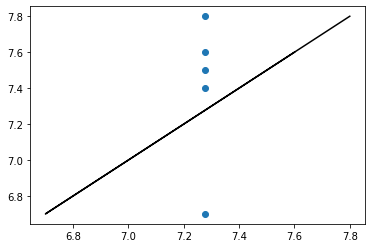

In [403]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

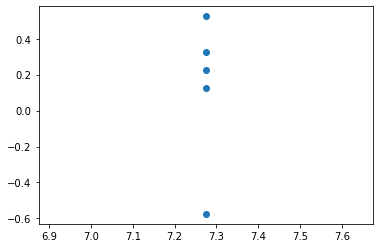

In [404]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [405]:
pd.options.display.float_format = "{:,.5f}".format



In [406]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

,Feature,Coefficient
0,year,0.00000
33,Vitus Zeplichal,-0.00000
35,Y Sa Lo,-0.00000
36,Elga Sorbas,-0.00000
37,Eva Mattes,0.00000
38,Peter Kern,0.00000
39,Hans Hirschmüller,0.00000
40,Marquard Bohm,0.00000
41,Armin Meier,-0.00000
42,Wolfgang Schenck,0.00000


In [407]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.3549999999999997,
 'coefficients':               Feature  Coefficient
 0                year      0.00000
 33    Vitus Zeplichal     -0.00000
 35            Y Sa Lo     -0.00000
 36        Elga Sorbas     -0.00000
 37         Eva Mattes      0.00000
 ..                ...          ...
 27      Brigitte Mira      0.00000
 28     Klaus Löwitsch      0.00000
 29       Adrian Hoven      0.00000
 30  El Hedi ben Salem      0.00000
 64           Udo Kier     -0.00000
 
 [65 rows x 2 columns]}

In [408]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_' + director
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [409]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [410]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, ridge_model.coef_))


In [411]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [412]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.32791202403665826

In [413]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

-0.02688663593384666

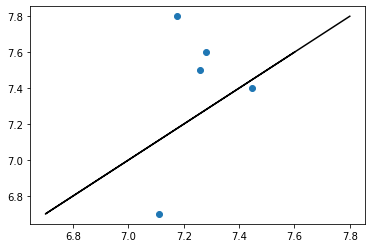

In [414]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

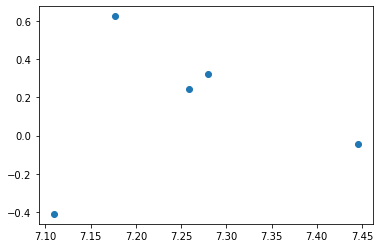

In [415]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [416]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

,Feature,Coefficient
1,duration,0.02913
17,Ulli Lommel,-0.02900
14,Irm Hermann,0.02865
23,Walter Sedlmayr,0.02575
30,El Hedi ben Salem,0.02240
24,Gottfried John,0.02185
52,Margarethe von Trotta,-0.02137
32,Peter Moland,-0.01919
41,Armin Meier,-0.01855
25,Rudolf Waldemar Brem,0.01794


In [417]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.32791202403665826,
 'coefficients':               Feature  Coefficient
 1            duration      0.02913
 17        Ulli Lommel     -0.02900
 14        Irm Hermann      0.02865
 23    Walter Sedlmayr      0.02575
 30  El Hedi ben Salem      0.02240
 ..                ...          ...
 37         Eva Mattes      0.00092
 12          Kurt Raab     -0.00069
 9         documentary      0.00000
 56        Franz Maron      0.00000
 58     Barbara Sukowa      0.00000
 
 [65 rows x 2 columns]}

In [418]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_' + director
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)

In [419]:
plt.scatter(y_test, y_pred)
plt.plot(y_pred, y_pred)
plt.plot(y_test, y_test)

NameError: name 'y_pred' is not defined